# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(data.head())
display(data.info())
display(data.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
#Минимальное значение цены равно нулю. Посмотрим, много ли таких объектов
data.columns = data.columns.str.lower()

data.query('price == 0')

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


In [5]:
#В данном случае мы можем убрать эти данные, так как они будут созвадать "шумовой" эффект в модели и только мешать нам

data = data.query('price != 0')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        343597 non-null  object
 1   price              343597 non-null  int64 
 2   vehicletype        309847 non-null  object
 3   registrationyear   343597 non-null  int64 
 4   gearbox            326242 non-null  object
 5   power              343597 non-null  int64 
 6   model              326076 non-null  object
 7   kilometer          343597 non-null  int64 
 8   registrationmonth  343597 non-null  int64 
 9   fueltype           314138 non-null  object
 10  brand              343597 non-null  object
 11  notrepaired        277731 non-null  object
 12  datecreated        343597 non-null  object
 13  numberofpictures   343597 non-null  int64 
 14  postalcode         343597 non-null  int64 
 15  lastseen           343597 non-null  object
dtypes: int64(7), object(

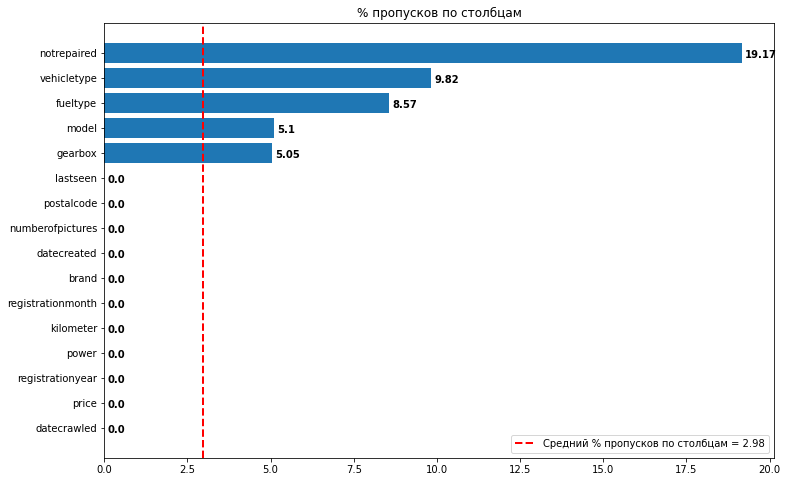

In [6]:
#Визуализируем количество пропусков по столбцам, чтобы лучше определить, что с ними делать

total_data = data.shape[0]
columns_data = data.columns.values.tolist()

nan = []

for col in columns_data:
    quantity_not_nan = data[col].count()
    percent_nan = ((total_data - quantity_not_nan) / total_data) * 100
    nan.append(percent_nan)
    
nan_percent = pd.Series(nan, index=columns_data)
nan_percent_mean = nan_percent.mean()
nan_percent.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
ax.barh(nan_percent.index, nan_percent.values)
ax.set_title('% пропусков по столбцам')

#построим линию, показывающую средний % пропусков по столбцам
plt.axvline(
    x=nan_percent_mean, linewidth=2,
    label='Средний % пропусков по столбцам = {}'.format(round(nan_percent_mean, 2)),
    color='r', linestyle='--')

plt.legend()

for i in ax.patches:
    plt.text(i.get_width()+0.1,
    i.get_y()+0.2, str(round(i.get_width(),2)),
    fontsize=10, fontweight='bold', color='black')

plt.show()

- Наибольшее кол-во пропусков содержится в столбце NotRepaired (19,17%) - их можно заполнить значением *unknown*, так как корректно его заполнить не получится основываясь на других данных;
- В столбце Vehicletype гораздо меньше пропусков (9,82%) - так же заполним на значения *unknown*;
- Fueltype - 8,57% пропусков: в принципе, можем заменить на значением *petrol*, так как все равно большинство машин ездит именно на бензине, а гибриды и электрокары появились не так давно (процент населения, приобретающий его, - мал);
- Столбцы Model и Gearbox содержать почти одинаковое кол-во пропусков (~5%). По каким-либо признакам, которые нам здесь даны, мы не смодем определить ни модель машины, ни коробку передать (робот, автомат или механика) - заполняем значением *unknown*.


In [7]:
change_list = ['notrepaired', 'vehicletype', 'model', 'gearbox']
for col in change_list:
    data[col].fillna('unknown', inplace=True)

In [8]:
data['fueltype'].value_counts()

petrol      210765
gasoline     97168
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: fueltype, dtype: int64

In [9]:
#как и предполагалось, большинство ездит на бензине
data['fueltype'].fillna('petrol', inplace=True)
data['fueltype'].isna().sum()

0

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        343597 non-null  object
 1   price              343597 non-null  int64 
 2   vehicletype        343597 non-null  object
 3   registrationyear   343597 non-null  int64 
 4   gearbox            343597 non-null  object
 5   power              343597 non-null  int64 
 6   model              343597 non-null  object
 7   kilometer          343597 non-null  int64 
 8   registrationmonth  343597 non-null  int64 
 9   fueltype           343597 non-null  object
 10  brand              343597 non-null  object
 11  notrepaired        343597 non-null  object
 12  datecreated        343597 non-null  object
 13  numberofpictures   343597 non-null  int64 
 14  postalcode         343597 non-null  int64 
 15  lastseen           343597 non-null  object
dtypes: int64(7), object(

*Пропуски заполнены, переходим к выбросам* 

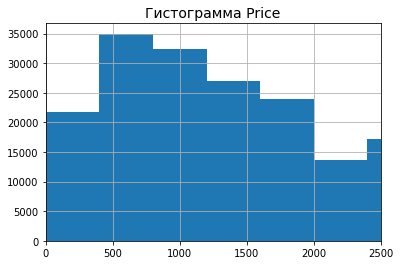

In [11]:
data['price'].hist(bins=50)
plt.title('Гистограмма Price', fontsize=14)
plt.xlim(0, 2500)
plt.show()

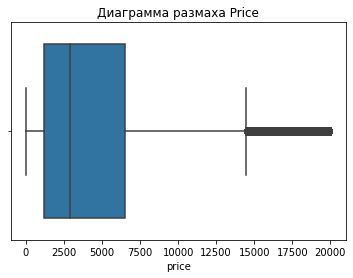

In [12]:
sns.boxplot(data['price'])
plt.title('Диаграмма размаха Price')
plt.show()

Значения до 400 евро похожи на выбросы, значения свыше 15000 евро - уже нет; скорее всего, там собраны элитные автомобили. Удалим из датафрема объекты с ценой менее 400 евро

In [13]:
data = data.query('price > 400')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321908 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        321908 non-null  object
 1   price              321908 non-null  int64 
 2   vehicletype        321908 non-null  object
 3   registrationyear   321908 non-null  int64 
 4   gearbox            321908 non-null  object
 5   power              321908 non-null  int64 
 6   model              321908 non-null  object
 7   kilometer          321908 non-null  int64 
 8   registrationmonth  321908 non-null  int64 
 9   fueltype           321908 non-null  object
 10  brand              321908 non-null  object
 11  notrepaired        321908 non-null  object
 12  datecreated        321908 non-null  object
 13  numberofpictures   321908 non-null  int64 
 14  postalcode         321908 non-null  int64 
 15  lastseen           321908 non-null  object
dtypes: int64(7), object(

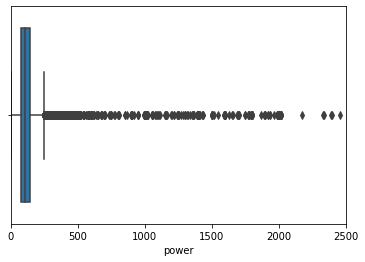

In [14]:
#в данных есть нулевые значения в столбце Power, рассмотрим их

sns.boxplot(data['power'])
plt.xlim(0,2500)
plt.show()

В нашем датафрейме есть автомобиль Trabant, его мощность 23 л.с. Будем считать его самым маломощным. Что касается самого мощного - едва ли обычные серийные автомобили превышают мощность в 500 л.с. По диаграмме размаха видно, что значения свыше 550 л.с. уже можно считать выбросами. Удалим значения до 23 л.с. и свыше 550 л.с.

In [15]:
data = data.query('23 <= power < 550')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291619 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        291619 non-null  object
 1   price              291619 non-null  int64 
 2   vehicletype        291619 non-null  object
 3   registrationyear   291619 non-null  int64 
 4   gearbox            291619 non-null  object
 5   power              291619 non-null  int64 
 6   model              291619 non-null  object
 7   kilometer          291619 non-null  int64 
 8   registrationmonth  291619 non-null  int64 
 9   fueltype           291619 non-null  object
 10  brand              291619 non-null  object
 11  notrepaired        291619 non-null  object
 12  datecreated        291619 non-null  object
 13  numberofpictures   291619 non-null  int64 
 14  postalcode         291619 non-null  int64 
 15  lastseen           291619 non-null  object
dtypes: int64(7), object(

<div class="alert alert-block alert-success">
    
<b>Успех:</b> С границами согласен

Также видим аномалии в годах регистрации автомобилей: минимальное значение 1000, максимальное 9999. Будем считать минимальным годом регистрации год начала продаж Trabant - 1957. Максимальным годом будем считать дату создания анкеты:

In [16]:
data['datecreated'].max()

'2016-04-07 00:00:00'

In [17]:
#Удалим все значения раньше 1957 года и позже 2016 года
data = data.query('1957 <= registrationyear <= 2016')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281601 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        281601 non-null  object
 1   price              281601 non-null  int64 
 2   vehicletype        281601 non-null  object
 3   registrationyear   281601 non-null  int64 
 4   gearbox            281601 non-null  object
 5   power              281601 non-null  int64 
 6   model              281601 non-null  object
 7   kilometer          281601 non-null  int64 
 8   registrationmonth  281601 non-null  int64 
 9   fueltype           281601 non-null  object
 10  brand              281601 non-null  object
 11  notrepaired        281601 non-null  object
 12  datecreated        281601 non-null  object
 13  numberofpictures   281601 non-null  int64 
 14  postalcode         281601 non-null  int64 
 15  lastseen           281601 non-null  object
dtypes: int64(7), object(

In [18]:
#Проверяем данные на дубликаты, при необходимости удаяем их

data.duplicated().sum()

4

In [19]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281597 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        281597 non-null  object
 1   price              281597 non-null  int64 
 2   vehicletype        281597 non-null  object
 3   registrationyear   281597 non-null  int64 
 4   gearbox            281597 non-null  object
 5   power              281597 non-null  int64 
 6   model              281597 non-null  object
 7   kilometer          281597 non-null  int64 
 8   registrationmonth  281597 non-null  int64 
 9   fueltype           281597 non-null  object
 10  brand              281597 non-null  object
 11  notrepaired        281597 non-null  object
 12  datecreated        281597 non-null  object
 13  numberofpictures   281597 non-null  int64 
 14  postalcode         281597 non-null  int64 
 15  lastseen           281597 non-null  object
dtypes: int64(7), object(

Для построения моделей не важны следующие параметры: дата создания анкеты, месяц регистрации автомобиля, дата скачивания анкеты из базы, количество фотографий автомобиля, почтовый код владельца анкеты, дата последней активности пользователя. Удалим эти столбцы, чтобы избежать лишнего шума в моделях и увеличить скорость вычислений.

In [20]:
data = data.drop(['lastseen', 'postalcode', 'numberofpictures', 'datecreated', 'registrationmonth',
                                                                              'datecrawled'], axis=1)

<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - хорошее решение
</div>


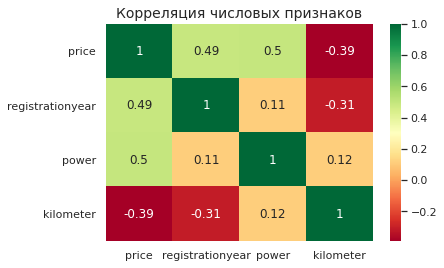

In [21]:
#Проверим признаки на мультиколлинеарность
numeric = data.drop(['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired'], axis=1)
sns.set(font_scale=1)
sns.heatmap(numeric.corr(), cmap='RdYlGn', annot=True)
plt.title('Корреляция числовых признаков', fontsize=14)

plt.show()

Мультиколлинеарности нет. Как и ожидалось - больше всего на цену автомобиля влияет год регистрации и мощность.

*Вывод*: 

Обработали пропуски, удалили выбросы и признаки, которые не представляли важности в данном исследовании. Переходим у подготовке признаков для обучения моделей и, непоосредственно, к самому обучению.

## Обучение моделей

### Подготовка данных

Для прогнозирования цены автомобиля будем использовать следующие модели:
- LinearRegression,
- Ridge,
- LGBMRegression,
- CatBoostRegression.

Для моделей LinearRegression и Ridge воспользуемся методом OHE(One-hot encoding) для кодирования категориальных признаков. Затем разобьем данные на обучающую и тестовую выборки в пропорции 80/20.

In [23]:
data_ohe = pd.get_dummies(data, drop_first=True)

target_linear = data_ohe['price']
features_linear = data_ohe.drop('price', axis=1)

features_train_linear, features_test_linear, target_train_linear, target_test_linear = train_test_split(
                                      features_linear, target_linear, test_size=0.2, random_state = 123)

print('Размер таблицы признаков обучающей выборки: ', features_train_linear.shape)
print('Размер таблицы признаков тестовой выборки: ', features_test_linear.shape)

Размер таблицы признаков обучающей выборки:  (225277, 309)
Размер таблицы признаков тестовой выборки:  (56320, 309)


In [24]:
#масштабируем признаки
scaler = StandardScaler()

numerical = ['registrationyear', 'power', 'kilometer']

scaler.fit(features_train_linear[numerical])

features_train_linear[numerical] = scaler.transform(features_train_linear[numerical])
features_test_linear[numerical] = scaler.transform(features_test_linear[numerical])

features_train_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_unknown,notrepaired_yes
243126,-0.010656,-0.143067,0.601116,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
220890,0.459898,0.754205,0.601116,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153765,-0.481211,3.427327,0.601116,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139464,1.087304,1.520624,-1.029226,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114925,1.401007,-0.329998,-1.572673,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
#Модели градиентного бустинга не умеют работать с типом object
#Изменим тип категориальных признаков на category

categorical = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

for col in categorical:
    data[col] = data[col].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281597 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   price             281597 non-null  int64   
 1   vehicletype       281597 non-null  category
 2   registrationyear  281597 non-null  int64   
 3   gearbox           281597 non-null  category
 4   power             281597 non-null  int64   
 5   model             281597 non-null  category
 6   kilometer         281597 non-null  int64   
 7   fueltype          281597 non-null  category
 8   brand             281597 non-null  category
 9   notrepaired       281597 non-null  category
dtypes: category(6), int64(4)
memory usage: 12.6 MB


In [27]:
#снова разбиваем данные на тестовую и обучающую выборку
target_boost = data['price']
features_boost = data.drop('price', axis=1)

features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
                                      features_boost, target_boost, test_size=0.2, random_state = 123)

print('Размер таблицы признаков обучающей выборки: ', features_train_boost.shape)
print('Размер таблицы признаков тестовой выборки: ', features_test_boost.shape)

Размер таблицы признаков обучающей выборки:  (225277, 9)
Размер таблицы признаков тестовой выборки:  (56320, 9)


In [28]:
#масштабируем признаки
scaler.fit(features_train_boost[numerical])

features_train_boost[numerical] = scaler.transform(features_train_boost[numerical])
features_test_boost[numerical] = scaler.transform(features_test_boost[numerical])

features_train_boost.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
243126,convertible,-0.010656,manual,-0.143067,beetle,0.601116,petrol,volkswagen,no
220890,wagon,0.459898,auto,0.754205,3er,0.601116,gasoline,bmw,no
153765,coupe,-0.481211,auto,3.427327,cl,0.601116,petrol,mercedes_benz,no
139464,sedan,1.087304,auto,1.520624,5er,-1.029226,gasoline,bmw,no
114925,sedan,1.401007,manual,-0.329998,leon,-1.572673,gasoline,seat,unknown


Напишем функцию, которая будет считать время обучения и время предсказания, а также RMSE моделей:

In [29]:
def model_final(model, X_train, y_train, X_test, y_test):
    
    start = time.time()    
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return train_time, predict_time, rmse

### Обучение моделей

In [30]:
#подберем оптимальные гиперпараметры с помощью GridSearchCV, проверим на тестовой выборке

model = LinearRegression()

search_space_linear = [{'fit_intercept': [True, False],
                        'normalize': [True, False]}]


gs_linear = GridSearchCV(model, 
                        search_space_linear, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

train_time_linear, predict_time_linear, rmse_linear = model_final(gs_linear, features_train_linear, 
                                                                               target_train_linear,
                                                                              features_test_linear, 
                                                                                target_test_linear)

print('Linear Regression:')
print('Время обучения: ', round(train_time_linear, 2), 'сек')
print('Время предсказания: ', round(predict_time_linear, 2), 'сек')
print('RMSE модели: ', round(rmse_linear, 2), 'евро')

Linear Regression:
Время обучения:  373.16 сек
Время предсказания:  0.19 сек
RMSE модели:  2534.74 евро


In [31]:
model = Ridge()

search_space_ridge = [{'fit_intercept': [True, False],
                       'normalize': [True, False],
                       'alpha': np.linspace(1, 3, num = 5)}]


gs_ridge = GridSearchCV(model, 
                        search_space_ridge, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

train_time_ridge, predict_time_ridge, rmse_ridge = model_final(gs_ridge, features_train_linear,
                                                                           target_train_linear,
                                                                          features_test_linear,
                                                                            target_test_linear)

print('Ridge:')
print('Время обучения: ', round(train_time_ridge, 2), 'сек')
print('Время предсказания: ', round(predict_time_ridge, 2), 'сек')
print('RMSE модели: ', round(rmse_ridge, 2), 'евро')

Ridge:
Время обучения:  264.6 сек
Время предсказания:  0.24 сек
RMSE модели:  2534.57 евро


In [32]:
model = LGBMRegressor(categorical_feature=categorical)

search_space_lgbm = [{'learning_rate': [0.05, 0.1],
                       'n_estimators': [100, 200],
                       'num_leaves': [31, 62]}]


gs_lgbm = GridSearchCV(model, 
                        search_space_lgbm, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

train_time_lgbm, predict_time_lgbm, rmse_lgbm = model_final(gs_lgbm, features_train_boost, target_train_boost,
                                                                       features_test_boost, target_test_boost)

print('LGBMRegressor:')
print('Время обучения: ', round(train_time_lgbm, 2), 'сек')
print('Время предсказания: ', round(predict_time_lgbm, 2), 'сек')
print('RMSE модели: ', round(rmse_lgbm, 2), 'евро')

LGBMRegressor:
Время обучения:  374.41 сек
Время предсказания:  1.3 сек
RMSE модели:  1510.64 евро


In [33]:
model = CatBoostRegressor(loss_function='RMSE', silent=True, cat_features=categorical)

search_space_catboost = [{'learning_rate': [0.03, 0.1],
                          'iterations': [40, 60, 80],
                          'depth': [4, 6, 8]}]


gs_catboost = GridSearchCV(model, 
                        search_space_catboost, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

train_time_catboost, predict_time_catboost, rmse_catboost = model_final(gs_catboost, features_train_boost,
                                                                                       target_train_boost,
                                                                                      features_test_boost,
                                                                                        target_test_boost)

print('CatBoost:')
print('Время обучения: ', round(train_time_catboost, 2), 'сек')
print('Время предсказания: ', round(predict_time_catboost, 2), 'сек')
print('RMSE модели: ', round(rmse_catboost, 2), 'евро')

CatBoost:
Время обучения:  444.74 сек
Время предсказания:  0.04 сек
RMSE модели:  1709.52 евро


## Анализ моделей

Для того, чтобы выснить, хорошо ли отрабатывают наши модели, нужно сравнить их с простой моделью. Воспользуемся DummyRegressor:

In [34]:
dummy = DummyRegressor(strategy='mean')

train_time_dummy, predict_time_dummy, rmse_dummy = model_final(dummy, features_train_linear, target_train_linear,
                                                                       features_test_linear, target_test_linear)

print('Dummy:')
print('Время обучения: ', round(train_time_dummy, 2), 'сек')
print('Время предсказания: ', round(predict_time_dummy, 2), 'сек')
print('RMSE модели: ', round(rmse_dummy, 2), 'евро')

Dummy:
Время обучения:  0.0 сек
Время предсказания:  0.0 сек
RMSE модели:  4589.04 евро


In [35]:
#Объединим результаты в сводную таблицу

df = {'Время обучения':[train_time_linear, train_time_ridge, train_time_lgbm, train_time_catboost,
                          train_time_dummy],
        
        'Время предсказания':[predict_time_linear, predict_time_ridge, predict_time_lgbm, predict_time_catboost,
                              predict_time_dummy],
        
       'RMSE':[rmse_linear, rmse_ridge, rmse_lgbm, rmse_catboost, rmse_dummy]}

table = pd.DataFrame(df)
table.index = ['LinearRegression', 'Ridge', 'LGBMRegressor', 'CatBoostRegressor', 'DummyRegressor']
pd.set_option('display.float_format', '{:.2f}'.format)
display(table)

,Время обучения,Время предсказания,RMSE
LinearRegression,373.16,0.19,2534.74
Ridge,264.60,0.24,2534.57
LGBMRegressor,374.41,1.30,1510.64
CatBoostRegressor,444.74,0.04,1709.52
DummyRegressor,0.00,0.00,4589.04


In [36]:
#сравним с медианной ценой автомобиля

data['price'].median()

3499.0

*В результате сравнения с константной моделью получили, что любая из наших моделей более предсказуема.*

## Вывод

Заказчику важны все три параметра: минимальная RMSE, скорость обучения и предсказания. Но достичь минимума сразу по всем параметрам сложно, поэтому нужно выбрать, что важнее. Учитывая медианную цену в 3499 евро, модели линейной LinearRegression и Ridge недостаточно предсказуемы, однако время обучение у модели Ridge самое быстрое. 

Рассмотрим LGBMRegressor и CatBoostRegressor. Минимум RMSE у LGBMRegressor (1510,64 евро), хотя эта модель обучается даже немного медленнее чем LinearRegression, а предсказывает медленнее всех. У CatBoostRegressor метрика RMSE на 11,6% выше, чем у LGBMRegressor; обучается модель дольше всех остальных моделей, но предсказывает быстрее остальных. 

Модели LGBMRegressor и CatBoostRegressor отвечают требованию по качеству предсказания, в целом. Дальше решение за заказчиком.